# Denoising with a synthetic DNN prior

Suppose we are given a prior $G$ parameterized by an expansive DNN. Suppose the prior $G$ maps a $k$-dimensional input to a $n$-dimensional output, where $K \ll N$. Furthermore, we let the weights be Gaussian distributed, and the activation functions are ReLus.

We consider the classical image or data denoising problem, where the goal is to remove zero-mean white Gaussian noise from a given image or data point. In more detail, our goal is to obtain an estimate of a vector $y_0 \in \mathbb R^n$ from the noisy observation
$$
y = y_0 + \eta, 
$$
where $\eta$ is zero-mean Gaussian noise with covariance matrix $\sigma^2/n I$, and $y_0$ lies in the range of the generator, i.e., $y_0=G(x_0)$.

We consider the following two-step denoising algorithm:
1. Obtaine an estimate $\hat x$ of the latent representation by minimizing the empirical loss
$$
f(x) = \|G(x) - y_0\|_2^2
$$
using gradient descent.
2. Obtain an estimate of the image as $\hat y = G(\hat x)$.

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

import numpy as np
from IPython.core.debugger import Tracer

import matplotlib.pyplot as plt

# Denoising with a random prior 
Suppose we add Gaussian noise to the output. What is the denoising rate if we reconstruct the input from the output, with empirical risk minimization?

In [2]:
def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 0.02)
            
def remove_grad(m):
    if type(m) == nn.Linear:
        m.weight.requires_grad = False

# generate a random DNN prior
def generate_random_prior(K):
    # define the network
    net = nn.Sequential(
        nn.Linear(in_features=K, out_features=300, bias=False),
        nn.ReLU(),
        nn.Linear(in_features=300, out_features=784, bias=False),
        nn.ReLU(),
    )
    # initialize weights
    net.apply(init_weights)
    net.apply(remove_grad)    
    return net

In [4]:
# function to estimate the latent representation
def invert_prior(net, noisy_image,latent_param,learning_rate=0.1,num_steps=10000):
    optimizer = torch.optim.SGD([latent_param], lr=learning_rate) 
    print('Optimizing..')
    iter_idx = 0
    while iter_idx <= num_steps:
        # correct the values of updated input signal
        optimizer.zero_grad()
        output = net(latent_param)
        loss = F.mse_loss(output, noisy_image, size_average=False)
        loss.backward()
        optimizer.step()
        iter_idx += 1
    return latent_param

# denoise by recovering estimating a latent representation and passing that through the decoder
def denoise(net,noisy_image,K):
    rec_rep = Variable(torch.randn(K), requires_grad=True)
    rec_rep = invert_prior(net, noisy_image, rec_rep)
    return net(rec_rep)

First, we demonstrate that in the noiseless case, we can perfectly recover the latent representation, provided $K$ is not too large:

In [5]:
def sqnorm(a):
    return sum(a.data.numpy()*a.data.numpy())
K = 50
net = generate_random_prior(K)
# generate random latent representation
orig_rep = Variable( torch.randn(K) )
orig_img = net(orig_rep) # 784 tensor
# recover image
rec_rep = Variable(torch.randn(K), requires_grad=True)
rec_rep = invert_prior(net, orig_img, rec_rep, 10.0)
MSErep = sqnorm(orig_rep - rec_rep) / sqnorm(rec_rep)
# MSE in image space:
rec_img = net(rec_rep)
MSE = sqnorm(orig_img - rec_img) / sqnorm(orig_img)
print("Mean square error in latent space (0 if perfect recovery): ",MSErep)
print("Mean square recovery error (0 if perfect recovery): ",MSE)

Optimizing..
Mean square error in latent space (0 if perfect recovery):  3.008122264660477e-13
Mean square recovery error (0 if perfect recovery):  8.326533718512951e-14


Generate the plots in the paper on the means square error:

In [6]:
def simulate(Ks,numit,sigma=0):
    MSEimg = np.zeros(len(Ks))
    MSErep = np.zeros(len(Ks))
    for i,K in enumerate(Ks):
        for it in range(numit):
            net = generate_random_prior(K)
            # generate random input to the network
            orig_rep = Variable( torch.randn(K) )
            orig_img = net(orig_rep)
            # add noise
            noise = Variable( torch.randn(784) )
            noise = noise * (sigma*np.sqrt(sqnorm(orig_img) / sqnorm(noise)))
            noisy_img = orig_img + noise
            if(sigma > 0):
                SNR = sqnorm(orig_img) / sqnorm(noise)
                print("SNR: ", SNR)
            # recover image
            rec_rep = Variable(torch.randn(K), requires_grad=True)
            rec_rep = invert_prior(net, noisy_img, rec_rep,10.0)
            # MSE in image space:
            rec_img = net(rec_rep)
            MSE = sqnorm(orig_img - rec_img) / sqnorm(orig_img)
            MSEimg[i] += MSE/numit
            # MSE in latent space:
            MSE = sqnorm(orig_rep - rec_rep) / sqnorm(orig_rep)
            MSErep[i] += MSE/numit
    return MSErep,MSEimg

numit = 100
Ks = [10+10*i for i in range(15)] + [170+20*i for i in range(17)]
print(Ks)
MSErep,MSEimg = simulate(Ks,numit,0)
MSErep05,MSEimg05 = simulate(Ks,numit,0.5)

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 170, 190, 210, 230, 250, 270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 470, 490]
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Opt

Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..

Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..

Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..

Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..

Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
Optimizing..
SNR:  3.9999998275803437
Optimizing..
SNR:  4.0000002328400655
Optimizing..
SNR:  4.000000250550762
Optimizing..
SNR:  3.999999949820929
Optimizing..
SNR:  3.9999996454911853
Optimizing..
SNR:  3.9999999964555717
Optimizing..
SNR:  3.999999685934909
Optimizin

SNR:  3.9999995649698348
Optimizing..
SNR:  4.000000133290448
Optimizing..
SNR:  3.9999998800892738
Optimizing..
SNR:  4.000000216764059
Optimizing..
SNR:  4.000000000718142
Optimizing..
SNR:  4.000000110436506
Optimizing..
SNR:  4.000000247184971
Optimizing..
SNR:  3.9999999198586567
Optimizing..
SNR:  4.000000156228209
Optimizing..
SNR:  3.999999958231896
Optimizing..
SNR:  3.999999915079029
Optimizing..
SNR:  4.0000000299987235
Optimizing..
SNR:  4.000000264924792
Optimizing..
SNR:  4.00000035531773
Optimizing..
SNR:  4.000000001104721
Optimizing..
SNR:  3.999999749487348
Optimizing..
SNR:  3.9999999647135014
Optimizing..
SNR:  3.9999998527432385
Optimizing..
SNR:  4.000000130249946
Optimizing..
SNR:  3.9999995794699075
Optimizing..
SNR:  3.9999998207155563
Optimizing..
SNR:  4.000000021643649
Optimizing..
SNR:  3.9999998849637963
Optimizing..
SNR:  3.999999752062354
Optimizing..
SNR:  4.000000166841028
Optimizing..
SNR:  3.999999795073032
Optimizing..
SNR:  4.0000004002977
Optimizi

SNR:  4.000000446375654
Optimizing..
SNR:  3.999999981930468
Optimizing..
SNR:  3.999999976893218
Optimizing..
SNR:  4.000000268143695
Optimizing..
SNR:  4.000000133251042
Optimizing..
SNR:  3.999999723318447
Optimizing..
SNR:  4.000000055930417
Optimizing..
SNR:  3.9999999118067855
Optimizing..
SNR:  4.000000051627244
Optimizing..
SNR:  3.999999892291926
Optimizing..
SNR:  4.000000178524302
Optimizing..
SNR:  4.000000153042909
Optimizing..
SNR:  3.999999773262934
Optimizing..
SNR:  3.999999961283416
Optimizing..
SNR:  4.00000011483095
Optimizing..
SNR:  4.000000373847886
Optimizing..
SNR:  4.000000261528803
Optimizing..
SNR:  3.9999997671601406
Optimizing..
SNR:  4.000000118967479
Optimizing..
SNR:  4.0000001935475415
Optimizing..
SNR:  3.9999997173021202
Optimizing..
SNR:  3.9999998549987814
Optimizing..
SNR:  3.9999997520176023
Optimizing..
SNR:  4.000000173948132
Optimizing..
SNR:  4.000000221059499
Optimizing..
SNR:  4.000000059942025
Optimizing..
SNR:  3.999999907764835
Optimizin

SNR:  4.000000036346963
Optimizing..
SNR:  4.000000082037393
Optimizing..
SNR:  4.000000082342686
Optimizing..
SNR:  4.000000105641335
Optimizing..
SNR:  4.000000119303208
Optimizing..
SNR:  4.000000161413638
Optimizing..
SNR:  4.000000245543327
Optimizing..
SNR:  3.999999869555403
Optimizing..
SNR:  4.000000165194471
Optimizing..
SNR:  3.9999998595459987
Optimizing..
SNR:  4.000000049362205
Optimizing..
SNR:  4.000000194074346
Optimizing..
SNR:  4.00000031463563
Optimizing..
SNR:  4.000000037417211
Optimizing..
SNR:  3.999999613317221
Optimizing..
SNR:  3.999999760074694
Optimizing..
SNR:  3.9999998116628968
Optimizing..
SNR:  3.9999999413908127
Optimizing..
SNR:  4.000000254454856
Optimizing..
SNR:  3.999999760776585
Optimizing..
SNR:  3.9999996946061396
Optimizing..
SNR:  4.000000266987871
Optimizing..
SNR:  3.9999997995077967
Optimizing..
SNR:  3.999999795363563
Optimizing..
SNR:  4.000000116229073
Optimizing..
SNR:  3.999999850874244
Optimizing..
SNR:  4.000000198120576
Optimizing

SNR:  4.000000299476638
Optimizing..
SNR:  3.9999997390658573
Optimizing..
SNR:  3.9999998774686674
Optimizing..
SNR:  4.000000098974085
Optimizing..
SNR:  3.9999999558220924
Optimizing..
SNR:  4.000000038920918
Optimizing..
SNR:  4.000000175379919
Optimizing..
SNR:  3.999999697435002
Optimizing..
SNR:  4.00000009960525
Optimizing..
SNR:  3.999999727123523
Optimizing..
SNR:  4.000000146133014
Optimizing..
SNR:  4.000000030435604
Optimizing..
SNR:  3.9999998526785396
Optimizing..
SNR:  3.9999996429104856
Optimizing..
SNR:  4.000000335581902
Optimizing..
SNR:  3.9999998777399024
Optimizing..
SNR:  3.9999999761932523
Optimizing..
SNR:  3.9999996103875963
Optimizing..
SNR:  4.000000117287205
Optimizing..
SNR:  3.999999622018868
Optimizing..
SNR:  3.9999998894489166
Optimizing..
SNR:  4.00000031825525
Optimizing..
SNR:  3.9999996911256086
Optimizing..
SNR:  3.99999961603771
Optimizing..
SNR:  3.9999997193305172
Optimizing..
SNR:  3.99999981211036
Optimizing..
SNR:  4.000000386552023
Optimiz

SNR:  4.000000143298394
Optimizing..
SNR:  4.000000013370561
Optimizing..
SNR:  3.999999628995052
Optimizing..
SNR:  4.000000182137273
Optimizing..
SNR:  4.000000395048926
Optimizing..
SNR:  4.0000001643127785
Optimizing..
SNR:  3.999999686634722
Optimizing..
SNR:  3.9999998723172325
Optimizing..
SNR:  4.000000231577057
Optimizing..
SNR:  4.000000392672513
Optimizing..
SNR:  4.000000064392883
Optimizing..
SNR:  4.00000010274607
Optimizing..
SNR:  4.00000009354087
Optimizing..
SNR:  3.9999996228481223
Optimizing..
SNR:  3.999999661902151
Optimizing..
SNR:  3.9999998970848503
Optimizing..
SNR:  4.000000121084616
Optimizing..
SNR:  4.000000317392297
Optimizing..
SNR:  3.9999999701596014
Optimizing..
SNR:  3.9999996516218443
Optimizing..
SNR:  4.000000367345983
Optimizing..
SNR:  4.000000179067966
Optimizing..
SNR:  3.9999997480760423
Optimizing..
SNR:  4.000000259795614
Optimizing..
SNR:  4.000000038332757
Optimizing..
SNR:  3.9999998093256215
Optimizing..
SNR:  3.9999999828976565
Optimiz

SNR:  3.9999997856548744
Optimizing..
SNR:  4.0000002091738445
Optimizing..
SNR:  3.9999998326227106
Optimizing..
SNR:  4.000000084895391
Optimizing..
SNR:  3.9999997412044697
Optimizing..
SNR:  4.000000260986844
Optimizing..
SNR:  3.999999742262171
Optimizing..
SNR:  4.000000088581926
Optimizing..
SNR:  4.000000157474321
Optimizing..
SNR:  4.000000202511689
Optimizing..
SNR:  4.000000358589794
Optimizing..
SNR:  3.9999998398667924
Optimizing..
SNR:  3.999999858804526
Optimizing..
SNR:  3.999999951297099
Optimizing..
SNR:  3.999999670708151
Optimizing..
SNR:  4.00000000460007
Optimizing..
SNR:  3.9999997443763835
Optimizing..
SNR:  3.9999997650435315
Optimizing..
SNR:  4.000000286790109
Optimizing..
SNR:  4.000000306417512
Optimizing..
SNR:  4.0000002668999555
Optimizing..
SNR:  3.999999903837141
Optimizing..
SNR:  3.999999976150882
Optimizing..
SNR:  3.9999999181972967
Optimizing..
SNR:  4.000000273425301
Optimizing..
SNR:  3.999999647133625
Optimizing..
SNR:  3.9999999695605486
Optim

SNR:  4.000000021313524
Optimizing..
SNR:  3.999999758761727
Optimizing..
SNR:  3.999999921650047
Optimizing..
SNR:  3.9999998060411466
Optimizing..
SNR:  3.9999999143545946
Optimizing..
SNR:  4.000000269339702
Optimizing..
SNR:  4.000000257688749
Optimizing..
SNR:  3.999999991309373
Optimizing..
SNR:  3.9999997177594833
Optimizing..
SNR:  3.9999998649798387
Optimizing..
SNR:  4.000000275264102
Optimizing..
SNR:  3.999999872964615
Optimizing..
SNR:  4.000000221422619
Optimizing..
SNR:  3.9999996566976477
Optimizing..
SNR:  4.000000260679374
Optimizing..
SNR:  3.9999997266395684
Optimizing..
SNR:  3.999999758030536
Optimizing..
SNR:  4.000000040466609
Optimizing..
SNR:  3.9999997734186317
Optimizing..
SNR:  3.9999999376350575
Optimizing..
SNR:  3.9999997448921714
Optimizing..
SNR:  3.9999996838861462
Optimizing..
SNR:  4.0000001453503975
Optimizing..
SNR:  3.999999714702733
Optimizing..
SNR:  4.00000002860674
Optimizing..
SNR:  3.9999998236505134
Optimizing..
SNR:  3.999999743960841
Opt

SNR:  3.999999900069194
Optimizing..
SNR:  4.000000200404864
Optimizing..
SNR:  3.9999998772880385
Optimizing..
SNR:  3.9999999066214045
Optimizing..
SNR:  3.999999970590777
Optimizing..
SNR:  4.000000223451048
Optimizing..
SNR:  3.9999999005347866
Optimizing..
SNR:  4.000000088080452
Optimizing..
SNR:  4.000000214630688
Optimizing..
SNR:  3.9999999791145844
Optimizing..
SNR:  4.000000296282276
Optimizing..
SNR:  3.999999906844762
Optimizing..
SNR:  4.000000117187408
Optimizing..
SNR:  3.999999847684489
Optimizing..
SNR:  4.000000067162199
Optimizing..
SNR:  3.9999998037500832
Optimizing..
SNR:  3.9999998813898263
Optimizing..
SNR:  4.000000073678209
Optimizing..
SNR:  4.000000189601146
Optimizing..
SNR:  3.9999998930053526
Optimizing..
SNR:  3.9999997062980084
Optimizing..
SNR:  3.9999997150730655
Optimizing..
SNR:  4.000000123577899
Optimizing..
SNR:  3.9999997113736008
Optimizing..
SNR:  3.999999761138917
Optimizing..
SNR:  4.000000186388492
Optimizing..
SNR:  3.999999784601626
Opti

SNR:  4.000000293269082
Optimizing..
SNR:  4.0000000184625675
Optimizing..
SNR:  3.999999998485859
Optimizing..
SNR:  3.999999854694303
Optimizing..
SNR:  4.0000000796576
Optimizing..
SNR:  3.9999997862158945
Optimizing..
SNR:  4.000000172622347
Optimizing..
SNR:  4.000000259292051
Optimizing..
SNR:  3.9999998817188835
Optimizing..
SNR:  3.9999999961963915
Optimizing..
SNR:  4.000000076604941
Optimizing..
SNR:  4.000000096368032
Optimizing..
SNR:  3.999999890988862
Optimizing..
SNR:  3.9999999257790373
Optimizing..
SNR:  4.000000008546294
Optimizing..
SNR:  4.000000226517402
Optimizing..
SNR:  4.000000175013198
Optimizing..
SNR:  3.9999997488053434
Optimizing..
SNR:  3.9999999790534146
Optimizing..
SNR:  3.999999984248619
Optimizing..
SNR:  3.9999998104322114
Optimizing..
SNR:  3.9999998628474702
Optimizing..
SNR:  3.9999998872833453
Optimizing..
SNR:  3.9999998436684505
Optimizing..
SNR:  3.9999996300554694
Optimizing..
SNR:  4.000000094236631
Optimizing..
SNR:  4.000000071535979
Opti

SNR:  4.0000002515136295
Optimizing..
SNR:  3.999999765675165
Optimizing..
SNR:  3.9999995801270725
Optimizing..
SNR:  4.000000183676341
Optimizing..
SNR:  4.000000200655338
Optimizing..
SNR:  4.000000266510878
Optimizing..
SNR:  3.9999997698480905
Optimizing..
SNR:  3.999999761889714
Optimizing..
SNR:  3.9999999660714445
Optimizing..
SNR:  3.9999998631722744
Optimizing..
SNR:  4.000000078117562
Optimizing..
SNR:  4.0000002443789064
Optimizing..
SNR:  3.999999822184834
Optimizing..
SNR:  4.000000047376555
Optimizing..
SNR:  4.000000242842591
Optimizing..
SNR:  3.9999996771997215
Optimizing..
SNR:  3.9999998506838033
Optimizing..
SNR:  4.000000042956263
Optimizing..
SNR:  4.000000013269915
Optimizing..
SNR:  3.9999999912414435
Optimizing..
SNR:  4.000000207725391
Optimizing..
SNR:  4.00000010026335
Optimizing..
SNR:  4.000000441728922
Optimizing..
SNR:  3.9999998759059348
Optimizing..
SNR:  3.999999942766566
Optimizing..
SNR:  3.999999950164524
Optimizing..
SNR:  3.9999999450671293
Opti

SNR:  4.000000075396894
Optimizing..
SNR:  4.000000292422919
Optimizing..
SNR:  3.9999997301198458
Optimizing..
SNR:  4.0000002998230215
Optimizing..
SNR:  4.000000236970067
Optimizing..
SNR:  4.000000346686004
Optimizing..
SNR:  4.000000184050365
Optimizing..
SNR:  4.00000006064336
Optimizing..
SNR:  3.9999998884517862
Optimizing..
SNR:  4.0000001200435
Optimizing..
SNR:  4.000000064495407
Optimizing..
SNR:  3.9999999020207104
Optimizing..
SNR:  4.000000247061712
Optimizing..
SNR:  4.000000110794055
Optimizing..
SNR:  4.000000052618547
Optimizing..
SNR:  4.00000007772126
Optimizing..
SNR:  3.9999999848862955
Optimizing..
SNR:  3.9999999774013126
Optimizing..
SNR:  4.000000226679128
Optimizing..
SNR:  4.000000166701825
Optimizing..
SNR:  4.000000347076045
Optimizing..
SNR:  3.999999657924013
Optimizing..
SNR:  3.999999725495907
Optimizing..
SNR:  3.9999998960410026
Optimizing..
SNR:  3.9999998971715685
Optimizing..
SNR:  3.9999995844198044
Optimizing..
SNR:  4.000000086185275
Optimizin

SNR:  3.999999725724293
Optimizing..
SNR:  3.999999911343122
Optimizing..
SNR:  4.000000375253614
Optimizing..
SNR:  3.999999787253324
Optimizing..
SNR:  4.000000302139994
Optimizing..
SNR:  4.000000396986713
Optimizing..
SNR:  3.9999997740273643
Optimizing..
SNR:  4.000000104431545
Optimizing..
SNR:  4.0000004085757945
Optimizing..
SNR:  4.000000015999307
Optimizing..
SNR:  4.00000048892634
Optimizing..
SNR:  4.000000134869046
Optimizing..
SNR:  4.000000283555146
Optimizing..
SNR:  4.000000075478888
Optimizing..
SNR:  4.0000002065084574
Optimizing..
SNR:  3.9999997343503293
Optimizing..
SNR:  4.000000112464177
Optimizing..
SNR:  4.000000247882271
Optimizing..
SNR:  4.000000199135685
Optimizing..
SNR:  4.000000120997499
Optimizing..
SNR:  3.9999998841185542
Optimizing..
SNR:  3.9999999523999867
Optimizing..
SNR:  3.9999999221968334
Optimizing..
SNR:  4.000000166085707
Optimizing..
SNR:  4.000000074758655
Optimizing..
SNR:  3.999999898840375
Optimizing..
SNR:  3.999999973295327
Optimizi

SNR:  4.000000228147483
Optimizing..
SNR:  3.9999998576480653
Optimizing..
SNR:  3.9999997895981787
Optimizing..
SNR:  4.0000000417702255
Optimizing..
SNR:  4.000000204761903
Optimizing..
SNR:  3.9999999732230465
Optimizing..
SNR:  3.999999901526898
Optimizing..
SNR:  3.9999995759095888
Optimizing..
SNR:  4.000000305315142
Optimizing..
SNR:  3.999999838144195
Optimizing..
SNR:  3.999999596556208
Optimizing..
SNR:  4.000000333457107
Optimizing..
SNR:  4.000000270621283
Optimizing..
SNR:  3.999999668634557
Optimizing..
SNR:  3.999999797240236
Optimizing..
SNR:  3.999999917965245
Optimizing..
SNR:  4.0000001666557505
Optimizing..
SNR:  3.99999952459661
Optimizing..
SNR:  4.000000035816404
Optimizing..
SNR:  4.000000301193366
Optimizing..
SNR:  3.999999996461663
Optimizing..
SNR:  4.000000191504274
Optimizing..
SNR:  4.0000000895894345
Optimizing..
SNR:  3.999999634280692
Optimizing..
SNR:  3.999999812443165
Optimizing..
SNR:  4.000000065938997
Optimizing..
SNR:  4.000000058214841
Optimizi

SNR:  3.999999747128275
Optimizing..
SNR:  3.999999850524048
Optimizing..
SNR:  4.0000001332929065
Optimizing..
SNR:  4.000000095459773
Optimizing..
SNR:  4.000000407620162
Optimizing..
SNR:  3.9999996849298016
Optimizing..
SNR:  3.9999998306437003
Optimizing..
SNR:  3.999999861954179
Optimizing..
SNR:  4.000000076902577
Optimizing..
SNR:  3.999999983006822
Optimizing..
SNR:  3.9999996542442227
Optimizing..
SNR:  3.9999997678772563
Optimizing..
SNR:  4.000000066020921
Optimizing..
SNR:  3.9999997936960976
Optimizing..
SNR:  4.000000348019998
Optimizing..
SNR:  3.999999993618385
Optimizing..
SNR:  3.999999888867394
Optimizing..
SNR:  4.00000012167352
Optimizing..
SNR:  3.9999998332142837
Optimizing..
SNR:  3.999999608898155
Optimizing..
SNR:  3.9999999617459365
Optimizing..
SNR:  4.000000116258813
Optimizing..
SNR:  4.000000259736448
Optimizing..
SNR:  4.000000292920354
Optimizing..
SNR:  3.9999997765775688
Optimizing..
SNR:  4.0000000224755565
Optimizing..
SNR:  3.999999770275722
Optim

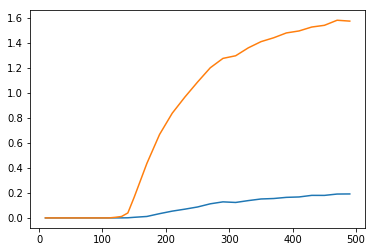

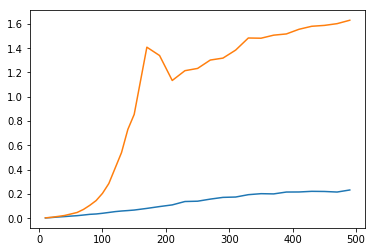

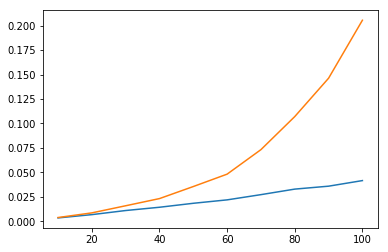

In [8]:
plt.plot(Ks,MSEimg)
plt.plot(Ks,MSErep)
plt.show()

plt.plot(Ks,MSEimg05)
plt.plot(Ks,MSErep05)
plt.show()

plt.plot(Ks[:10],MSEimg05[:10])
plt.plot(Ks[:10],MSErep05[:10])
plt.show()

mtx = np.array([Ks, 0.5**2*np.array(Ks)/782, MSEimg, MSErep, MSEimg05, MSErep05])
np.savetxt("./denoise_random_dnn.dat", mtx.T , delimiter='\t')

## Visualization of the loss surface

In [27]:
def sqnorm(a):
    return sum(a.data.numpy()*a.data.numpy())
K = 2
net = generate_random_prior(K)
# generate latent representation at (1,0)
orig_rep = Variable( torch.ones(2) )
orig_rep.data[1] = 0
orig_img = net(orig_rep) # 784 tensor

N = 10
zgrid = [i/N for i in range(-2*N,2*N)]
ygrid = [i/N for i in range(-1*N,1*N)]

# print coordinates plotted with pgfplots

for i,y in enumerate(ygrid):
    for j,z in  enumerate(zgrid):
        x = Variable( torch.ones(2) )
        x.data[0] = z
        x.data[1] = y
        loss = sqnorm(net(x) - orig_img)
        print(y,z,loss)
    print()

-1.0 -2.0 0.03461677806349084
-1.0 -1.9 0.032300592760595756
-1.0 -1.8 0.030086662280912904
-1.0 -1.7 0.02799403689934032
-1.0 -1.6 0.026016759934420874
-1.0 -1.5 0.02415746130676967
-1.0 -1.4 0.022429125695154928
-1.0 -1.3 0.020809516648095328
-1.0 -1.2 0.019268353049968878
-1.0 -1.1 0.017849271442107798
-1.0 -1.0 0.016550721957390338
-1.0 -0.9 0.015356901733903743
-1.0 -0.8 0.01425514511958026
-1.0 -0.7 0.013238199547324407
-1.0 -0.6 0.01234419526504879
-1.0 -0.5 0.01150677867008204
-1.0 -0.4 0.010757347423409613
-1.0 -0.3 0.010068561140470108
-1.0 -0.2 0.009423081943245176
-1.0 -0.1 0.008839488584909669
-1.0 0.0 0.008333804924895924
-1.0 0.1 0.007839582568935188
-1.0 0.2 0.007416778538980498
-1.0 0.3 0.007117643754294092
-1.0 0.4 0.006926320401118069
-1.0 0.5 0.006796222598329885
-1.0 0.6 0.006737096124589503
-1.0 0.7 0.006809912330033363
-1.0 0.8 0.007011833418988726
-1.0 0.9 0.007274242481322066
-1.0 1.0 0.007644751075622867
-1.0 1.1 0.008151124770398088
-1.0 1.2 0.008812737318158

0.0 -1.2 0.01226388214468923
0.0 -1.1 0.011217698610488679
0.0 -1.0 0.010307705445785114
0.0 -0.9 0.009533903025334507
0.0 -0.8 0.00889629130592129
0.0 -0.7 0.008394869822278713
0.0 -0.6 0.008029638847927161
0.0 -0.5 0.007800598004033161
0.0 -0.4 0.007707747861179878
0.0 -0.3 0.007751088111854169
0.0 -0.2 0.007930618620452128
0.0 -0.1 0.008246339696189896
0.0 0.0 0.008698251192575945
0.0 0.1 0.007045583403062383
0.0 0.2 0.005566880766419646
0.0 0.3 0.004262142983358003
0.0 0.4 0.0031313703953600724
0.0 0.5 0.0021745627981439863
0.0 0.6 0.0013917200998979362
0.0 0.7 0.0007828426712310765
0.0 0.8 0.0003479300260087262
0.0 0.9 8.698256027490827e-05
0.0 1.0 0.0
0.0 1.1 8.698255796730191e-05
0.0 1.2 0.0003479301422643112
0.0 1.3 0.0007828423335823065
0.0 1.4 0.0013917200181609857
0.0 1.5 0.0021745626725336864
0.0 1.6 0.003131370566057695
0.0 1.7 0.004262143599158996
0.0 1.8 0.0055668799795453305
0.0 1.9 0.0070455827807754945

0.1 -2.0 0.02556111137488297
0.1 -1.9 0.023426405368053623
0.1 -1

0.7 -0.5 0.00987038151962355
0.7 -0.4 0.009270817524685948
0.7 -0.3 0.008741848173527682
0.7 -0.2 0.008247076006737804
0.7 -0.1 0.007818898727286666
0.7 0.0 0.007361568487219694
0.7 0.1 0.006855523974844999
0.7 0.2 0.006390250806685205
0.7 0.3 0.005909824358076604
0.7 0.4 0.0053590717964202075
0.7 0.5 0.004845088135075858
0.7 0.6 0.004365410905218747
0.7 0.7 0.003915453346600246
0.7 0.8 0.003515168164614494
0.7 0.9 0.0032452526859026026
0.7 1.0 0.003109300248122419
0.7 1.1 0.003117317472022034
0.7 1.2 0.0032906307813658497
0.7 1.3 0.0036164715679722244
0.7 1.4 0.004114489033869406
0.7 1.5 0.0047789467924675005
0.7 1.6 0.005605801158787546
0.7 1.7 0.0065993411014827145
0.7 1.8 0.007764437258160081
0.7 1.9 0.009100747382077312

0.8 -2.0 0.031372238250531995
0.8 -1.9 0.029169760331002666
0.8 -1.8 0.027091974313440514
0.8 -1.7 0.02513833654842915
0.8 -1.6 0.023329596387435203
0.8 -1.5 0.021639639657360127
0.8 -1.4 0.02007631956765818
0.8 -1.3 0.01863431597976463
0.8 -1.2 0.0172961037751622